# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [47]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [48]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [49]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [50]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [51]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [52]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [53]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [54]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [55]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [56]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = random_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [57]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 126, 0.0: 126})
Counter({0.0: 63, 1.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [58]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [60]:
#Taxa de aprendizagem, e usada a mesma em todo o codigo
learnRate = 0.01

In [59]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [61]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 1.4488 - acc: 0.6270 - val_loss: 2.7300 - val_acc: 0.5476
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.9287 - acc: 0.6310 - val_loss: 1.7723 - val_acc: 0.5952
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5747 - acc: 0.5873 - val_loss: 1.2226 - val_acc: 0.5952
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4546 - acc: 0.5952 - val_loss: 0.8932 - val_acc: 0.5794
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3942 - acc: 0.6071 - val_loss: 0.7044 - val_acc: 0.5873
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.3276 - acc: 0.6270 - val_loss: 0.6244 - val_acc: 0.5952
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.2868 - acc: 0.6706 - val_loss: 0.5462 - val_acc: 0.6270
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.2513 - acc

252/252 [==============================] - 0s - loss: 0.0856 - acc: 0.8929 - val_loss: 0.0904 - val_acc: 0.8651
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.8968 - val_loss: 0.0895 - val_acc: 0.8651
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.0851 - acc: 0.8968 - val_loss: 0.0900 - val_acc: 0.8651
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.8968 - val_loss: 0.0906 - val_acc: 0.8651
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.0850 - acc: 0.8929 - val_loss: 0.0896 - val_acc: 0.8651
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8929 - val_loss: 0.0899 - val_acc: 0.8651
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.0848 - acc: 0.8968 - val_loss: 0.0889 - val_acc: 0.8651
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.0846 - acc: 0.8929 - val_loss: 0.0877 - val_acc: 0.8730
Epoch 

252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.8968 - val_loss: 0.0829 - val_acc: 0.8810
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.8968 - val_loss: 0.0824 - val_acc: 0.8810
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.8968 - val_loss: 0.0827 - val_acc: 0.8810
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.8968 - val_loss: 0.0826 - val_acc: 0.8889
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.8968 - val_loss: 0.0826 - val_acc: 0.8889
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.8968 - val_loss: 0.0823 - val_acc: 0.8889
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.8968 - val_loss: 0.0827 - val_acc: 0.8810
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.8968 - val_loss: 0.0824 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0815 - val_acc: 0.9048
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9008 - val_loss: 0.0810 - val_acc: 0.9048
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9008 - val_loss: 0.0831 - val_acc: 0.9048
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9008 - val_loss: 0.0811 - val_acc: 0.8968
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9008 - val_loss: 0.0827 - val_acc: 0.9048
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9008 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0831 - val_acc: 0.9048
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9008 - val_loss: 0.0817 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.8968
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.8968 - val_loss: 0.0813 - val_acc: 0.9048
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9008 - val_loss: 0.0816 - val_acc: 0.9048
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9048 - val_loss: 0.0814 - val_acc: 0.9127
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9048 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9048 - val_loss: 0.0807 - val_acc: 0.9048
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0828 - val_acc: 0.8968
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9048 - val_loss: 0.0807 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9048 - val_loss: 0.0811 - val_acc: 0.9048
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9048 - val_loss: 0.0817 - val_acc: 0.8968
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.8968
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9008 - val_loss: 0.0836 - val_acc: 0.8968
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.0813 - val_acc: 0.9048
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9048 - val_loss: 0.0847 - val_acc: 0.8968
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9087 - val_loss: 0.0812 - val_acc: 0.9048
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9048 - val_loss: 0.0827 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9048 - val_loss: 0.0805 - val_acc: 0.8968
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.0831 - val_acc: 0.8968
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9008 - val_loss: 0.0804 - val_acc: 0.8968
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9008 - val_loss: 0.0818 - val_acc: 0.8968
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9048 - val_loss: 0.0858 - val_acc: 0.8889
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.0809 - val_acc: 0.8968
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9008 - val_loss: 0.0815 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9008 - val_loss: 0.0871 - val_acc: 0.8968
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9008 - val_loss: 0.0803 - val_acc: 0.9048
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9008 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9008 - val_loss: 0.0803 - val_acc: 0.9048
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9008 - val_loss: 0.0813 - val_acc: 0.9048
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9048 - val_loss: 0.0835 - val_acc: 0.9048
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9008 - val_loss: 0.0802 - val_acc: 0.9048
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9008 - val_loss: 0.0814 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9087 - val_loss: 0.0807 - val_acc: 0.9048
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.0816 - val_acc: 0.9048
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0828 - val_acc: 0.9048
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9008 - val_loss: 0.0817 - val_acc: 0.9048
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9048 - val_loss: 0.0818 - val_acc: 0.9048
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0802 - val_acc: 0.9048
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0808 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.0834 - val_acc: 0.9048
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0814 - val_acc: 0.8968
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0802 - val_acc: 0.9048
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.0812 - val_acc: 0.8968
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0845 - val_acc: 0.9048
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9048 - val_loss: 0.0802 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0802 - val_acc: 0.8968
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9087 - val_loss: 0.0874 - val_acc: 0.8968
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.0810 - val_acc: 0.8968
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9048 - val_loss: 0.0885 - val_acc: 0.8968
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9087 - val_loss: 0.0804 - val_acc: 0.9048
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9087 - val_loss: 0.0823 - val_acc: 0.9048
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9008 - val_loss: 0.0849 - val_acc: 0.8968
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9048 - val_loss: 0.0805 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9087 - val_loss: 0.0821 - val_acc: 0.9048
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0805 - val_acc: 0.8968
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9008 - val_loss: 0.0841 - val_acc: 0.8968
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9008 - val_loss: 0.0808 - val_acc: 0.8968
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.0849 - val_acc: 0.8968
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9087 - val_loss: 0.0821 - val_acc: 0.9048
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0805 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.0819 - val_acc: 0.9048
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9008 - val_loss: 0.0814 - val_acc: 0.9048
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9087 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9008 - val_loss: 0.0811 - val_acc: 0.9048
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9008 - val_loss: 0.0896 - val_acc: 0.8968
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9087 - val_loss: 0.0854 - val_acc: 0.8968
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9008 - val_loss: 0.0811 - val_acc: 0.8968
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0831 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9087 - val_loss: 0.0923 - val_acc: 0.8968
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9048 - val_loss: 0.0804 - val_acc: 0.9048
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0815 - val_acc: 0.9048
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.0807 - val_acc: 0.9048
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0807 - val_acc: 0.9048
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0818 - val_acc: 0.8968
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9087 - val_loss: 0.0991 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0808 - val_acc: 0.9048
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0827 - val_acc: 0.9048
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0823 - val_acc: 0.9048
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.0809 - val_acc: 0.8968
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9087 - val_loss: 0.0803 - val_acc: 0.9048
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0816 - val_acc: 0.9048
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9008 - val_loss: 0.0890 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9087 - val_loss: 0.0828 - val_acc: 0.9048
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.0815 - val_acc: 0.9048
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0816 - val_acc: 0.9048
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9048 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9048 - val_loss: 0.0835 - val_acc: 0.9048
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.0830 - val_acc: 0.9048
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0814 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9048 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0812 - val_acc: 0.9048
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9048 - val_loss: 0.0824 - val_acc: 0.9048
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.0812 - val_acc: 0.9048
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0807 - val_acc: 0.9048
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0842 - val_acc: 0.8968
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9087 - val_loss: 0.0803 - val_acc: 0.9048
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9048 - val_loss: 0.0863 - val_acc:

252/252 [==============================] - 0s - loss: 0.0771 - acc: 0.9008 - val_loss: 0.0877 - val_acc: 0.8968
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.0813 - val_acc: 0.9048
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0830 - val_acc: 0.9048
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9008 - val_loss: 0.0831 - val_acc: 0.9048
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.0812 - val_acc: 0.9048
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9008 - val_loss: 0.0807 - val_acc: 0.8968
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9048 - val_loss: 0.0948 - val_acc: 0.8889
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.8968 - val_loss: 0.0825 - val_acc:

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0807 - val_acc: 0.9048
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0912 - val_acc: 0.8968
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0803 - val_acc: 0.9127
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.0836 - val_acc: 0.8968
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9048 - val_loss: 0.0812 - val_acc: 0.9048
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0829 - val_acc: 0.9048
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9008 - val_loss: 0.0817 - val_acc:

252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0810 - val_acc: 0.8968
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.0856 - val_acc: 0.8968
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0801 - val_acc: 0.9048
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9008 - val_loss: 0.0811 - val_acc: 0.9048
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9048 - val_loss: 0.0845 - val_acc: 0.8968
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9087 - val_loss: 0.0821 - val_acc: 0.9048
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0808 - val_acc: 0.9048
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9008 - val_loss: 0.0809 - val_acc:

252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9008 - val_loss: 0.0836 - val_acc: 0.8968
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.8968 - val_loss: 0.0919 - val_acc: 0.8968
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9087 - val_loss: 0.0810 - val_acc: 0.9048
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9008 - val_loss: 0.0823 - val_acc: 0.9048
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0768 - acc: 0.9048 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9008 - val_loss: 0.0840 - val_acc: 0.9048
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.0825 - val_acc:

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0835 - val_acc: 0.9048
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9048 - val_loss: 0.0803 - val_acc: 0.9048
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9087 - val_loss: 0.0830 - val_acc: 0.9048
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0830 - val_acc: 0.9048
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9048 - val_loss: 0.0846 - val_acc: 0.9048
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9048 - val_loss: 0.0902 - val_acc: 0.8968
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9008 - val_loss: 0.0803 - val_acc: 0.9048
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9048 - val_loss: 0.0824 - val_acc:

252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0834 - val_acc: 0.9048
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9008 - val_loss: 0.0802 - val_acc: 0.9048
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9087 - val_loss: 0.0931 - val_acc: 0.8968
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9087 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9008 - val_loss: 0.0838 - val_acc: 0.9048
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9087 - val_loss: 0.0810 - val_acc: 0.8968
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0889 - val_acc: 0.8968
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9008 - val_loss: 0.0812 - val_acc:

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0850 - val_acc: 0.8968
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9008 - val_loss: 0.0813 - val_acc: 0.8968
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9008 - val_loss: 0.0831 - val_acc: 0.9048
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9048 - val_loss: 0.0834 - val_acc: 0.8968
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9008 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0833 - val_acc: 0.8968
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0816 - val_acc:

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9087 - val_loss: 0.0820 - val_acc: 0.9048
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9087 - val_loss: 0.0802 - val_acc: 0.9048
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9008 - val_loss: 0.0817 - val_acc: 0.9048
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9008 - val_loss: 0.0841 - val_acc: 0.8968
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0813 - val_acc: 0.9048
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0830 - val_acc: 0.9048
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.0810 - val_acc:

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.0815 - val_acc: 0.9048
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9008 - val_loss: 0.0825 - val_acc: 0.9048
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.0836 - val_acc: 0.9048
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9008 - val_loss: 0.0805 - val_acc: 0.9048
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0839 - val_acc: 0.8968
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0820 - val_acc: 0.9048
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9048 - val_loss: 0.0816 - val_acc:

252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9048 - val_loss: 0.0835 - val_acc: 0.9048
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0834 - val_acc: 0.9048
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0816 - val_acc: 0.8968
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9008 - val_loss: 0.0832 - val_acc: 0.9048
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9008 - val_loss: 0.0805 - val_acc: 0.9048
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.0815 - val_acc:

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.0820 - val_acc: 0.9048
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9087 - val_loss: 0.0824 - val_acc: 0.8968
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9087 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0770 - acc: 0.9048 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0819 - val_acc: 0.9048
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.0803 - val_acc: 0.9048
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9008 - val_loss: 0.0811 - val_acc:

252/252 [==============================] - 0s - loss: 0.0766 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9008 - val_loss: 0.0844 - val_acc: 0.8968
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9008 - val_loss: 0.0804 - val_acc: 0.9048
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0809 - val_acc: 0.9048
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9008 - val_loss: 0.0810 - val_acc: 0.9048
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9087 - val_loss: 0.0834 - val_acc: 0.9048
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9008 - val_loss: 0.0809 - val_acc:

252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9008 - val_loss: 0.0810 - val_acc: 0.9048
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9087 - val_loss: 0.0847 - val_acc: 0.8968
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0819 - val_acc: 0.9048
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0814 - val_acc: 0.9048
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9008 - val_loss: 0.0811 - val_acc: 0.9048
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9048 - val_loss: 0.0925 - val_acc: 0.8968
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9048 - val_loss: 0.0803 - val_acc: 0.9127
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0784 - acc: 0.9008 - val_loss: 0.0813 - val_acc:

252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0804 - val_acc: 0.9048
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0844 - val_acc: 0.8968
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0817 - val_acc: 0.9048
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9048 - val_loss: 0.0813 - val_acc: 0.9048
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9087 - val_loss: 0.0857 - val_acc: 0.8968
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9008 - val_loss: 0.0806 - val_acc: 0.8968
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.0851 - val_acc: 0.8968
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9008 - val_loss: 0.0806 - val_acc:

252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9087 - val_loss: 0.0843 - val_acc: 0.8968
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9008 - val_loss: 0.0809 - val_acc: 0.8968
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.0937 - val_acc: 0.8968
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9048 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9008 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0769 - acc: 0.9008 - val_loss: 0.0811 - val_acc: 0.9048
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0757 - acc: 0.9008 - val_loss: 0.0824 - val_acc: 0.9048
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0755 - acc: 0.9008 - val_loss: 0.0810 - val_acc:

In [62]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.056180549999100902, 0.9281345565749235]


<IPython.core.display.Javascript object>


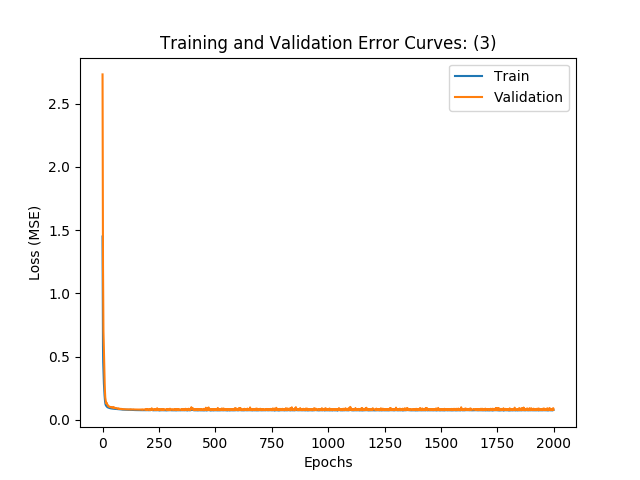

<IPython.core.display.Javascript object>


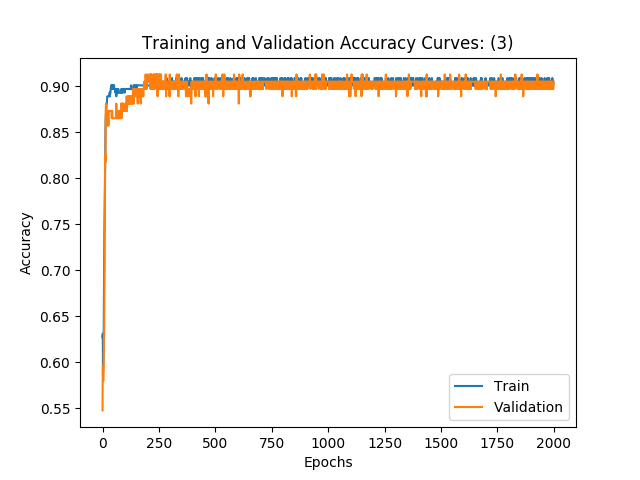

Matriz de confusão
[[1764  134]
 [   7   57]]

Train Loss:       0.0759
Validation Loss:  0.0800
Accuracy:         0.9281
MSE:              0.0719
AUROC:            0.9404


In [63]:
plot_training_error_curves(history, "(3)")
plot_training_acc_curves(history, "(3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (5)

In [23]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5952 - acc: 0.6032 - val_loss: 0.5946 - val_acc: 0.6429
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3179 - acc: 0.6667 - val_loss: 0.4657 - val_acc: 0.6984
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2275 - acc: 0.7302 - val_loss: 0.3824 - val_acc: 0.7302
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1841 - acc: 0.7817 - val_loss: 0.3197 - val_acc: 0.7619
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1607 - acc: 0.8175 - val_loss: 0.2616 - val_acc: 0.7937
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1422 - acc: 0.8333 - val_loss: 0.2366 - val_acc: 0.8254
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1309 - acc: 0.8492 - val_loss: 0.2104 - val_acc: 0.8492
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1188 - acc

252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.9206 - val_loss: 0.0920 - val_acc: 0.8968
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.9127 - val_loss: 0.0923 - val_acc: 0.8968
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9127 - val_loss: 0.0926 - val_acc: 0.9048
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.0929 - val_acc: 0.9048
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.0738 - acc: 0.9127 - val_loss: 0.0913 - val_acc: 0.9048
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9048 - val_loss: 0.0921 - val_acc: 0.9048
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.0737 - acc: 0.9127 - val_loss: 0.0899 - val_acc: 0.9048
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.0887 - val_acc: 0.8968
Epoch 

252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9206 - val_loss: 0.0804 - val_acc: 0.8968
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9246 - val_loss: 0.0777 - val_acc: 0.9286
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9246 - val_loss: 0.0782 - val_acc: 0.9286
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9206 - val_loss: 0.0796 - val_acc: 0.9286
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9286 - val_loss: 0.0782 - val_acc: 0.9206
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.0776 - val_acc: 0.9127
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9246 - val_loss: 0.0789 - val_acc: 0.9286
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9246 - val_loss: 0.0785 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9325 - val_loss: 0.0780 - val_acc: 0.9127
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0790 - val_acc: 0.9206
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0592 - acc: 0.9325 - val_loss: 0.0804 - val_acc: 0.9127
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0812 - val_acc: 0.9127
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9286 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9325 - val_loss: 0.0797 - val_acc: 0.8968
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.0806 - val_acc: 0.9048
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.0806 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9365 - val_loss: 0.0849 - val_acc: 0.8889
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9405 - val_loss: 0.0825 - val_acc: 0.8968
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9365 - val_loss: 0.0851 - val_acc: 0.8968
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0559 - acc: 0.9405 - val_loss: 0.0834 - val_acc: 0.8889
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0813 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9365 - val_loss: 0.0853 - val_acc: 0.8968
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0560 - acc: 0.9405 - val_loss: 0.0817 - val_acc: 0.8889
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9405 - val_loss: 0.0943 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9405 - val_loss: 0.0833 - val_acc: 0.8968
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9405 - val_loss: 0.0829 - val_acc: 0.8968
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0549 - acc: 0.9405 - val_loss: 0.0821 - val_acc: 0.8968
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9405 - val_loss: 0.0835 - val_acc: 0.8889
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9405 - val_loss: 0.0802 - val_acc: 0.9048
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9246 - val_loss: 0.0873 - val_acc: 0.9048
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9405 - val_loss: 0.0842 - val_acc: 0.8968
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9405 - val_loss: 0.0865 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9405 - val_loss: 0.0823 - val_acc: 0.8968
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9405 - val_loss: 0.0806 - val_acc: 0.8968
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9405 - val_loss: 0.0812 - val_acc: 0.8968
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9405 - val_loss: 0.0826 - val_acc: 0.8968
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9405 - val_loss: 0.0812 - val_acc: 0.8968
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9405 - val_loss: 0.0839 - val_acc: 0.8889
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9405 - val_loss: 0.0781 - val_acc: 0.9048
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9405 - val_loss: 0.0832 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9405 - val_loss: 0.0839 - val_acc: 0.9048
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9405 - val_loss: 0.0809 - val_acc: 0.8968
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9405 - val_loss: 0.0792 - val_acc: 0.9048
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0559 - acc: 0.9405 - val_loss: 0.0818 - val_acc: 0.8889
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9325 - val_loss: 0.0798 - val_acc: 0.8968
Epoch 454/2000
252/252 [==============================] - ETA: 0s - loss: 0.0570 - acc: 0.937 - 0s - loss: 0.0562 - acc: 0.9365 - val_loss: 0.0946 - val_acc: 0.9048
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9405 - val_loss: 0.0870 - val_acc: 0.8968
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.936

252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9286 - val_loss: 0.0859 - val_acc: 0.9048
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9286 - val_loss: 0.0875 - val_acc: 0.8968
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.0852 - val_acc: 0.9048
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9325 - val_loss: 0.0861 - val_acc: 0.9048
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9286 - val_loss: 0.0853 - val_acc: 0.9048
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9325 - val_loss: 0.0879 - val_acc: 0.8968
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9325 - val_loss: 0.0855 - val_acc: 0.8968
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.9325 - val_loss: 0.0900 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9325 - val_loss: 0.0846 - val_acc: 0.8968
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0859 - val_acc: 0.9048
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0864 - val_acc: 0.8968
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0871 - val_acc: 0.8968
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.0867 - val_acc: 0.8968
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0862 - val_acc: 0.9048
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0860 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0862 - val_acc: 0.8968
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0860 - val_acc: 0.8968
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9325 - val_loss: 0.0843 - val_acc: 0.9048
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0854 - val_acc: 0.9048
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0850 - val_acc: 0.9048
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.0859 - val_acc: 0.8968
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9325 - val_loss: 0.0861 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.0834 - val_acc: 0.9048
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0842 - val_acc: 0.8968
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.0837 - val_acc: 0.9048
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0826 - val_acc: 0.9048
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0830 - val_acc: 0.9048
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9325 - val_loss: 0.0829 - val_acc: 0.9048
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9325 - val_loss: 0.0833 - val_acc: 0.9048
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0823 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.0923 - val_acc: 0.8889
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.0922 - val_acc: 0.8968
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.0925 - val_acc: 0.8889
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.0925 - val_acc: 0.8889
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9325 - val_loss: 0.0927 - val_acc: 0.8889
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.0908 - val_acc: 0.9048
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.0935 - val_acc: 0.8810
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.0929 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9286 - val_loss: 0.0943 - val_acc: 0.8889
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9325 - val_loss: 0.0918 - val_acc: 0.9048
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9286 - val_loss: 0.0915 - val_acc: 0.8889
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9365 - val_loss: 0.0919 - val_acc: 0.8968
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9286 - val_loss: 0.0938 - val_acc: 0.8889
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9286 - val_loss: 0.0948 - val_acc: 0.8889
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.0920 - val_acc: 0.8889
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9286 - val_loss: 0.0933 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9325 - val_loss: 0.0978 - val_acc: 0.8889
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9286 - val_loss: 0.0939 - val_acc: 0.8889
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9286 - val_loss: 0.0937 - val_acc: 0.8889
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9325 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9325 - val_loss: 0.0962 - val_acc: 0.8889
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9286 - val_loss: 0.0954 - val_acc: 0.8889
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9325 - val_loss: 0.0931 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9286 - val_loss: 0.0963 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9365 - val_loss: 0.0960 - val_acc: 0.8889
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9365 - val_loss: 0.0959 - val_acc: 0.8889
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9325 - val_loss: 0.0958 - val_acc: 0.8810
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9286 - val_loss: 0.0968 - val_acc: 0.8810
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9286 - val_loss: 0.0961 - val_acc: 0.8810
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9286 - val_loss: 0.0958 - val_acc: 0.8889
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9286 - val_loss: 0.0969 - val_acc: 0.8810
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.0955 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9365 - val_loss: 0.0946 - val_acc: 0.8968
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.0970 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9286 - val_loss: 0.0960 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9286 - val_loss: 0.0953 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9286 - val_loss: 0.0958 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9286 - val_loss: 0.0981 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9286 - val_loss: 0.0974 - val_acc:

252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9325 - val_loss: 0.0977 - val_acc: 0.8889
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9365 - val_loss: 0.0971 - val_acc: 0.8889
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9365 - val_loss: 0.0977 - val_acc: 0.8889
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0959 - val_acc: 0.8889
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9365 - val_loss: 0.0966 - val_acc: 0.8889
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9325 - val_loss: 0.0979 - val_acc: 0.8889
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9365 - val_loss: 0.0962 - val_acc: 0.8889
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9325 - val_loss: 0.0974 - val_acc:

252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.0963 - val_acc: 0.8889
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9325 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9325 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0970 - val_acc: 0.8889
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9365 - val_loss: 0.0962 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9365 - val_loss: 0.0991 - val_acc: 0.8889
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9246 - val_loss: 0.0982 - val_acc:

252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9325 - val_loss: 0.0948 - val_acc: 0.8968
Epoch 1216/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9365 - val_loss: 0.0969 - val_acc: 0.8889
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9365 - val_loss: 0.0947 - val_acc: 0.8889
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9365 - val_loss: 0.0979 - val_acc: 0.8889
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.0964 - val_acc: 0.8968
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9325 - val_loss: 0.0964 - val_acc: 0.8889
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9325 - val_loss: 0.0973 - val_acc:

252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9325 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9365 - val_loss: 0.0950 - val_acc: 0.8968
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0963 - val_acc: 0.8889
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9325 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0950 - val_acc: 0.8968
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0977 - val_acc: 0.8889
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9365 - val_loss: 0.0966 - val_acc:

252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9325 - val_loss: 0.0971 - val_acc: 0.8889
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0963 - val_acc: 0.8889
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9365 - val_loss: 0.0957 - val_acc: 0.8889
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9325 - val_loss: 0.0971 - val_acc: 0.8889
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9365 - val_loss: 0.0948 - val_acc: 0.8889
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9325 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0959 - val_acc:

252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9325 - val_loss: 0.0976 - val_acc: 0.8889
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9365 - val_loss: 0.0945 - val_acc: 0.8968
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9365 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0965 - val_acc: 0.8889
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9365 - val_loss: 0.0949 - val_acc: 0.8968
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0951 - val_acc:

252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9325 - val_loss: 0.0948 - val_acc: 0.8810
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9325 - val_loss: 0.0963 - val_acc: 0.8889
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0962 - val_acc: 0.8889
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0949 - val_acc: 0.8968
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9325 - val_loss: 0.0970 - val_acc: 0.8889
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0944 - val_acc: 0.8968
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9365 - val_loss: 0.0954 - val_acc: 0.8889
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0947 - val_acc:

252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9365 - val_loss: 0.0953 - val_acc: 0.8968
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0958 - val_acc: 0.8889
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9325 - val_loss: 0.0975 - val_acc: 0.8889
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9365 - val_loss: 0.0948 - val_acc: 0.8968
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9325 - val_loss: 0.0949 - val_acc: 0.8810
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0959 - val_acc: 0.8968
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9365 - val_loss: 0.0965 - val_acc: 0.8968
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9365 - val_loss: 0.0960 - val_acc:

252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0949 - val_acc: 0.8968
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9365 - val_loss: 0.0938 - val_acc: 0.8968
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0955 - val_acc: 0.8889
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0985 - val_acc: 0.8889
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9325 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9365 - val_loss: 0.0945 - val_acc: 0.8968
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0972 - val_acc: 0.8889
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9365 - val_loss: 0.0952 - val_acc:

252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9365 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9365 - val_loss: 0.0954 - val_acc: 0.8889
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9365 - val_loss: 0.0952 - val_acc: 0.8968
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0973 - val_acc: 0.8889
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9325 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9365 - val_loss: 0.0956 - val_acc: 0.8968
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9325 - val_loss: 0.0961 - val_acc: 0.8889
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0953 - val_acc:

252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9365 - val_loss: 0.0949 - val_acc: 0.8968
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9365 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9365 - val_loss: 0.0960 - val_acc: 0.8889
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9365 - val_loss: 0.0969 - val_acc: 0.8889
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0961 - val_acc: 0.8968
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0970 - val_acc: 0.8889
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9365 - val_loss: 0.0957 - val_acc: 0.8889
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9365 - val_loss: 0.0952 - val_acc:

252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0968 - val_acc: 0.8889
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0968 - val_acc: 0.8889
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9325 - val_loss: 0.0963 - val_acc: 0.8968
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0942 - val_acc: 0.8968
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0955 - val_acc: 0.8889
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9365 - val_loss: 0.0959 - val_acc: 0.8889
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0952 - val_acc:

252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9365 - val_loss: 0.0945 - val_acc: 0.8968
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9365 - val_loss: 0.0960 - val_acc: 0.8889
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9365 - val_loss: 0.0974 - val_acc: 0.8889
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0967 - val_acc: 0.8889
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9365 - val_loss: 0.0962 - val_acc: 0.8968
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0954 - val_acc: 0.8968
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9365 - val_loss: 0.0937 - val_acc:

252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9365 - val_loss: 0.0948 - val_acc: 0.8968
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0954 - val_acc: 0.8889
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9325 - val_loss: 0.0960 - val_acc: 0.8889
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0951 - val_acc: 0.8968
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9365 - val_loss: 0.0958 - val_acc: 0.8968
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9365 - val_loss: 0.0972 - val_acc: 0.8889
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9325 - val_loss: 0.0946 - val_acc: 0.8968
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9365 - val_loss: 0.0946 - val_acc:

252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9365 - val_loss: 0.0956 - val_acc: 0.8889
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9365 - val_loss: 0.0969 - val_acc: 0.8889
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9365 - val_loss: 0.0955 - val_acc: 0.8968
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0963 - val_acc: 0.8889
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0960 - val_acc: 0.8889
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9365 - val_loss: 0.0958 - val_acc: 0.8889
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9365 - val_loss: 0.0948 - val_acc: 0.8968
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9365 - val_loss: 0.0961 - val_acc:

In [24]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.071697462080511726, 0.90316004065320155]


<IPython.core.display.Javascript object>


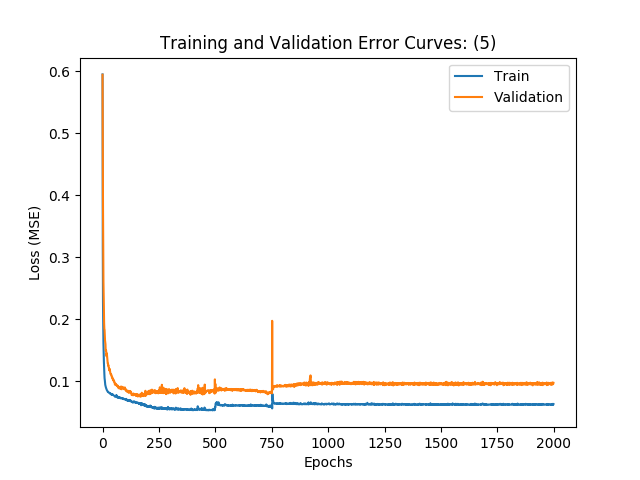

<IPython.core.display.Javascript object>


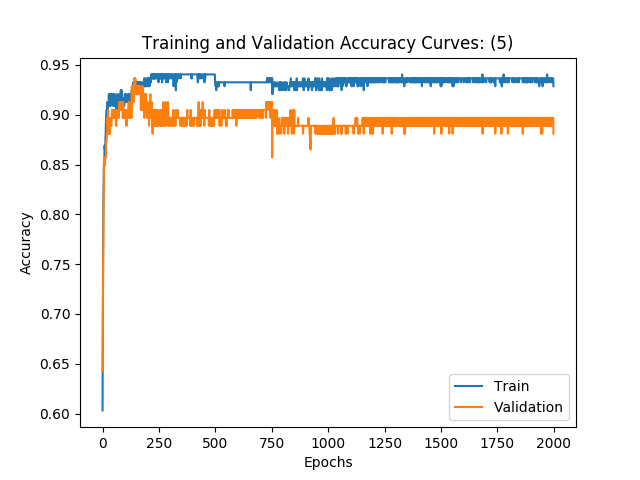

Matriz de confusão
[[1719  179]
 [  11   53]]

Train Loss:       0.0644
Validation Loss:  0.0749
Accuracy:         0.9032
MSE:              0.0968
AUROC:            0.9208


In [25]:
plot_training_error_curves(history, "(5)")
plot_training_acc_curves(history, "(5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (3, 5)

In [121]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.2391 - acc: 0.6468 - val_loss: 0.2628 - val_acc: 0.7222
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.1669 - acc: 0.7698 - val_loss: 0.2615 - val_acc: 0.7698
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.1429 - acc: 0.8373 - val_loss: 0.1866 - val_acc: 0.8016
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1243 - acc: 0.8611 - val_loss: 0.1558 - val_acc: 0.8333
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8770 - val_loss: 0.1473 - val_acc: 0.8492
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8770 - val_loss: 0.1344 - val_acc: 0.8492
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8849 - val_loss: 0.1222 - val_acc: 0.8492
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc

252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9087 - val_loss: 0.0978 - val_acc: 0.8810
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9087 - val_loss: 0.0945 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9087 - val_loss: 0.0971 - val_acc: 0.8810
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.0949 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9087 - val_loss: 0.0945 - val_acc: 0.8810
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9127 - val_loss: 0.0969 - val_acc: 0.8810
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9087 - val_loss: 0.0929 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9087 - val_loss: 0.0943 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9167 - val_loss: 0.0936 - val_acc: 0.8730
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9127 - val_loss: 0.0929 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9127 - val_loss: 0.0935 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9167 - val_loss: 0.0944 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9087 - val_loss: 0.0942 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9127 - val_loss: 0.0961 - val_acc: 0.8492
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9167 - val_loss: 0.0978 - val_acc: 0.8571
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9167 - val_loss: 0.0943 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9206 - val_loss: 0.0984 - val_acc: 0.8730
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9206 - val_loss: 0.0985 - val_acc: 0.8651
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9286 - val_loss: 0.0965 - val_acc: 0.8730
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9206 - val_loss: 0.1002 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9167 - val_loss: 0.0994 - val_acc: 0.8730
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9206 - val_loss: 0.1000 - val_acc: 0.8730
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9246 - val_loss: 0.0999 - val_acc: 0.8730
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0650 - acc: 0.9206 - val_loss: 0.1128 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9206 - val_loss: 0.1147 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9246 - val_loss: 0.1195 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9246 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9286 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9286 - val_loss: 0.1201 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9206 - val_loss: 0.1170 - val_acc: 0.8651
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9206 - val_loss: 0.1151 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9286 - val_loss: 0.1148 - val_acc: 0.8571
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9286 - val_loss: 0.1151 - val_acc: 0.8571
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9286 - val_loss: 0.1161 - val_acc: 0.8571
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9286 - val_loss: 0.1168 - val_acc: 0.8651
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0620 - acc: 0.9286 - val_loss: 0.1169 - val_acc: 0.8571
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9286 - val_loss: 0.1167 - val_acc: 0.8651
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9286 - val_loss: 0.1166 - val_acc: 0.8651
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9246 - val_loss: 0.1225 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9286 - val_loss: 0.1124 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9286 - val_loss: 0.1133 - val_acc: 0.8651
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0613 - acc: 0.9286 - val_loss: 0.1202 - val_acc: 0.8651
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9325 - val_loss: 0.1147 - val_acc: 0.8571
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9246 - val_loss: 0.1125 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9246 - val_loss: 0.1096 - val_acc: 0.8571
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0613 - acc: 0.9246 - val_loss: 0.1101 - val_acc: 0.8651
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9286 - val_loss: 0.1109 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9405 - val_loss: 0.1127 - val_acc: 0.8810
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9365 - val_loss: 0.1120 - val_acc: 0.8810
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0559 - acc: 0.9365 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0564 - acc: 0.9365 - val_loss: 0.1087 - val_acc: 0.8889
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0564 - acc: 0.9405 - val_loss: 0.1126 - val_acc: 0.8810
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9325 - val_loss: 0.1134 - val_acc: 0.8810
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9365 - val_loss: 0.1098 - val_acc: 0.8889
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.1182 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9325 - val_loss: 0.1160 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9365 - val_loss: 0.1148 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9325 - val_loss: 0.1156 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1177 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9286 - val_loss: 0.1149 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9286 - val_loss: 0.1159 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9325 - val_loss: 0.1168 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1141 - val_acc:

252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9365 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9325 - val_loss: 0.1094 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9365 - val_loss: 0.1095 - val_acc: 0.8889
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9365 - val_loss: 0.1055 - val_acc: 0.8889
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9286 - val_loss: 0.1074 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.1089 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9246 - val_loss: 0.1037 - val_acc: 0.8889
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9286 - val_loss: 0.1144 - val_acc:

252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.9127 - val_loss: 0.1118 - val_acc: 0.8730
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9167 - val_loss: 0.1086 - val_acc: 0.8730
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9246 - val_loss: 0.1082 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9286 - val_loss: 0.1086 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0756 - acc: 0.9206 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9246 - val_loss: 0.1107 - val_acc: 0.8810
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0709 - acc: 0.9167 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9286 - val_loss: 0.1150 - val_acc:

252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9325 - val_loss: 0.1106 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9325 - val_loss: 0.1115 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9325 - val_loss: 0.1098 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9325 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9325 - val_loss: 0.1110 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9365 - val_loss: 0.1115 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1110 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9365 - val_loss: 0.1114 - val_acc:

252/252 [==============================] - 0s - loss: 0.0652 - acc: 0.9365 - val_loss: 0.1073 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1174 - val_acc: 0.8730
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9365 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9365 - val_loss: 0.1131 - val_acc: 0.8730
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9365 - val_loss: 0.1082 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9286 - val_loss: 0.1059 - val_acc: 0.8810
Epoch 1543/2000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9365 - val_loss: 0.1108 - val_acc:

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9365 - val_loss: 0.1111 - val_acc: 0.8730
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0652 - acc: 0.9365 - val_loss: 0.1071 - val_acc: 0.8730
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9365 - val_loss: 0.1089 - val_acc: 0.8730
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9325 - val_loss: 0.1186 - val_acc: 0.8651
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9325 - val_loss: 0.1276 - val_acc: 0.8492
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9286 - val_loss: 0.1131 - val_acc: 0.8730
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9365 - val_loss: 0.1134 - val_acc: 0.8730
Epoch 1671/2000
252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9325 - val_loss: 0.1124 - val_acc:

252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9365 - val_loss: 0.1078 - val_acc: 0.8651
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9365 - val_loss: 0.1079 - val_acc: 0.8651
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0652 - acc: 0.9365 - val_loss: 0.1045 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9325 - val_loss: 0.1034 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9365 - val_loss: 0.1093 - val_acc: 0.8730
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9365 - val_loss: 0.1099 - val_acc: 0.8651
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9325 - val_loss: 0.1037 - val_acc: 0.8810
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0651 - acc: 0.9325 - val_loss: 0.1006 - val_acc:

252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9325 - val_loss: 0.1166 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9365 - val_loss: 0.1091 - val_acc: 0.8730
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9325 - val_loss: 0.1065 - val_acc: 0.8730
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9325 - val_loss: 0.1146 - val_acc: 0.8730
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9286 - val_loss: 0.1225 - val_acc: 0.8651
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9325 - val_loss: 0.1097 - val_acc: 0.8651
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9365 - val_loss: 0.1081 - val_acc: 0.8730
Epoch 1926/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9365 - val_loss: 0.1145 - val_acc:

In [122]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.064014763389586199, 0.93119266055045868]


/home/opcinove/.virtualenvs/python3.6env/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


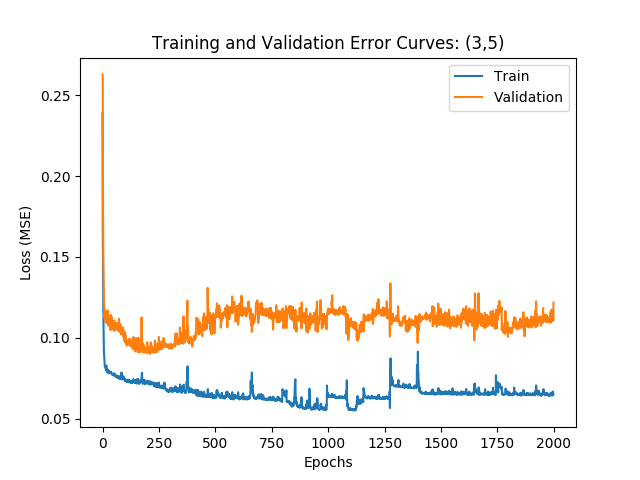

<IPython.core.display.Javascript object>


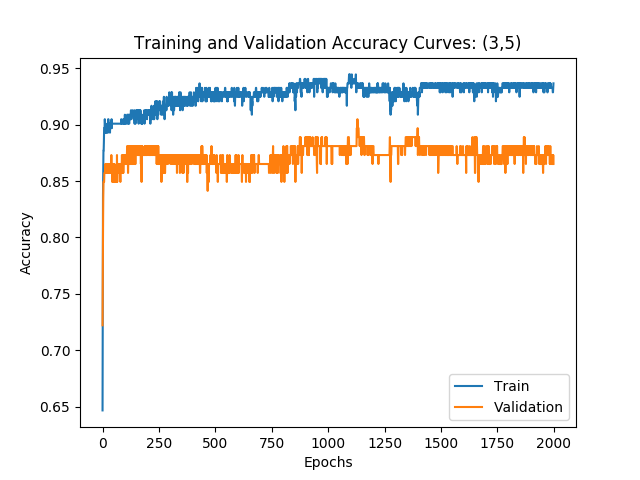

Matriz de confusão
[[1774  124]
 [  10   54]]

Train Loss:       0.0712
Validation Loss:  0.0900
Accuracy:         0.9317
MSE:              0.0683
AUROC:            0.8963


In [123]:
plot_training_error_curves(history, "(3,5)")
plot_training_acc_curves(history, "(3,5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (5,3)

In [127]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='tanh')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.3993 - acc: 0.3690 - val_loss: 0.3018 - val_acc: 0.4206
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2174 - acc: 0.6310 - val_loss: 0.1818 - val_acc: 0.7540
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.1396 - acc: 0.8056 - val_loss: 0.1328 - val_acc: 0.8333
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1140 - acc: 0.8373 - val_loss: 0.1128 - val_acc: 0.8810
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1019 - acc: 0.8770 - val_loss: 0.1032 - val_acc: 0.8889
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.0952 - acc: 0.8770 - val_loss: 0.0977 - val_acc: 0.8889
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8849 - val_loss: 0.0963 - val_acc: 0.8810
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.0851 - acc

252/252 [==============================] - 0s - loss: 0.0559 - acc: 0.9246 - val_loss: 0.0885 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9325 - val_loss: 0.0883 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.8810
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9246 - val_loss: 0.0865 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9365 - val_loss: 0.0901 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9286 - val_loss: 0.0922 - val_acc: 0.8571
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0558 - acc: 0.9286 - val_loss: 0.0891 - val_acc: 0.8730
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0572 - acc: 0.9286 - val_loss: 0.0915 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0421 - acc: 0.9563 - val_loss: 0.1075 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0390 - acc: 0.9603 - val_loss: 0.1101 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0408 - acc: 0.9563 - val_loss: 0.1087 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0413 - acc: 0.9563 - val_loss: 0.1101 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0407 - acc: 0.9563 - val_loss: 0.1097 - val_acc: 0.8571
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0401 - acc: 0.9563 - val_loss: 0.1106 - val_acc: 0.8651
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0462 - acc: 0.9484 - val_loss: 0.1099 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0440 - acc: 0.9524 - val_loss: 0.1111 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0356 - acc: 0.9643 - val_loss: 0.1293 - val_acc: 0.8492
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0374 - acc: 0.9643 - val_loss: 0.1287 - val_acc: 0.8413
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0360 - acc: 0.9643 - val_loss: 0.1282 - val_acc: 0.8413
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0372 - acc: 0.9643 - val_loss: 0.1328 - val_acc: 0.8413
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0356 - acc: 0.9643 - val_loss: 0.1316 - val_acc: 0.8492
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0381 - acc: 0.9563 - val_loss: 0.1283 - val_acc: 0.8571
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0408 - acc: 0.9603 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0393 - acc: 0.9524 - val_loss: 0.1350 - val_acc: 0.8413

252/252 [==============================] - 0s - loss: 0.0379 - acc: 0.9603 - val_loss: 0.1381 - val_acc: 0.8413
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0379 - acc: 0.9603 - val_loss: 0.1384 - val_acc: 0.8492
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0381 - acc: 0.9603 - val_loss: 0.1385 - val_acc: 0.8492
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0383 - acc: 0.9603 - val_loss: 0.1382 - val_acc: 0.8492
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0380 - acc: 0.9563 - val_loss: 0.1418 - val_acc: 0.8413
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0388 - acc: 0.9563 - val_loss: 0.1378 - val_acc: 0.8413
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0380 - acc: 0.9603 - val_loss: 0.1334 - val_acc: 0.8492
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0380 - acc: 0.9603 - val_loss: 0.1389 - val_acc: 0.8413

252/252 [==============================] - 0s - loss: 0.0375 - acc: 0.9603 - val_loss: 0.1471 - val_acc: 0.8413
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0382 - acc: 0.9603 - val_loss: 0.1401 - val_acc: 0.8413
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0383 - acc: 0.9563 - val_loss: 0.1485 - val_acc: 0.8413
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0377 - acc: 0.9603 - val_loss: 0.1410 - val_acc: 0.8413
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0376 - acc: 0.9603 - val_loss: 0.1367 - val_acc: 0.8333
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0385 - acc: 0.9603 - val_loss: 0.1449 - val_acc: 0.8413
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0389 - acc: 0.9563 - val_loss: 0.1452 - val_acc: 0.8413
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0386 - acc: 0.9603 - val_loss: 0.1450 - val_acc: 0.8413

252/252 [==============================] - 0s - loss: 0.0366 - acc: 0.9643 - val_loss: 0.1370 - val_acc: 0.8413
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0368 - acc: 0.9603 - val_loss: 0.1393 - val_acc: 0.8413
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0366 - acc: 0.9603 - val_loss: 0.1406 - val_acc: 0.8413
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0371 - acc: 0.9603 - val_loss: 0.1439 - val_acc: 0.8413
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0366 - acc: 0.9603 - val_loss: 0.1445 - val_acc: 0.8413
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0385 - acc: 0.9563 - val_loss: 0.1441 - val_acc: 0.8413
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0367 - acc: 0.9603 - val_loss: 0.1338 - val_acc: 0.8492
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0391 - acc: 0.9603 - val_loss: 0.1386 - val_acc: 0.8413

252/252 [==============================] - 0s - loss: 0.0424 - acc: 0.9563 - val_loss: 0.1499 - val_acc: 0.8333
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0426 - acc: 0.9563 - val_loss: 0.1454 - val_acc: 0.8333
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0424 - acc: 0.9563 - val_loss: 0.1440 - val_acc: 0.8333
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0407 - acc: 0.9563 - val_loss: 0.1512 - val_acc: 0.8333
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0420 - acc: 0.9563 - val_loss: 0.1490 - val_acc: 0.8413
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0414 - acc: 0.9563 - val_loss: 0.1408 - val_acc: 0.8413
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0411 - acc: 0.9563 - val_loss: 0.1406 - val_acc: 0.8413
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0406 - acc: 0.9563 - val_loss: 0.1468 - val_acc: 0.8413

252/252 [==============================] - 0s - loss: 0.0370 - acc: 0.9563 - val_loss: 0.1529 - val_acc: 0.8333
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0388 - acc: 0.9563 - val_loss: 0.1569 - val_acc: 0.8254
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0361 - acc: 0.9603 - val_loss: 0.1534 - val_acc: 0.8254
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0378 - acc: 0.9563 - val_loss: 0.1545 - val_acc: 0.8254
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0375 - acc: 0.9563 - val_loss: 0.1613 - val_acc: 0.8175
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0365 - acc: 0.9603 - val_loss: 0.1625 - val_acc: 0.8175
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0359 - acc: 0.9603 - val_loss: 0.1633 - val_acc: 0.8175
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0362 - acc: 0.9603 - val_loss: 0.1623 - val_acc:

252/252 [==============================] - 0s - loss: 0.0335 - acc: 0.9683 - val_loss: 0.1549 - val_acc: 0.8333
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0346 - acc: 0.9643 - val_loss: 0.1490 - val_acc: 0.8413
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0368 - acc: 0.9643 - val_loss: 0.1472 - val_acc: 0.8413
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0342 - acc: 0.9643 - val_loss: 0.1482 - val_acc: 0.8413
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0369 - acc: 0.9643 - val_loss: 0.1503 - val_acc: 0.8413
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0427 - acc: 0.9524 - val_loss: 0.1374 - val_acc: 0.8413
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0389 - acc: 0.9563 - val_loss: 0.1522 - val_acc: 0.8333
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0368 - acc: 0.9643 - val_loss: 0.1439 - val_acc:

252/252 [==============================] - 0s - loss: 0.0354 - acc: 0.9643 - val_loss: 0.1374 - val_acc: 0.8571
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0358 - acc: 0.9643 - val_loss: 0.1448 - val_acc: 0.8492
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0367 - acc: 0.9603 - val_loss: 0.1451 - val_acc: 0.8492
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0377 - acc: 0.9603 - val_loss: 0.1380 - val_acc: 0.8571
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0373 - acc: 0.9603 - val_loss: 0.1390 - val_acc: 0.8571
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0364 - acc: 0.9643 - val_loss: 0.1427 - val_acc: 0.8492
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0354 - acc: 0.9643 - val_loss: 0.1388 - val_acc: 0.8571
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0366 - acc: 0.9643 - val_loss: 0.1403 - val_acc:

252/252 [==============================] - 0s - loss: 0.0462 - acc: 0.9524 - val_loss: 0.1469 - val_acc: 0.8413
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0463 - acc: 0.9524 - val_loss: 0.1468 - val_acc: 0.8413
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0461 - acc: 0.9524 - val_loss: 0.1471 - val_acc: 0.8413
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0461 - acc: 0.9524 - val_loss: 0.1473 - val_acc: 0.8413
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0464 - acc: 0.9524 - val_loss: 0.1477 - val_acc: 0.8413
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0461 - acc: 0.9524 - val_loss: 0.1467 - val_acc: 0.8413
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0461 - acc: 0.9524 - val_loss: 0.1462 - val_acc: 0.8413
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0462 - acc: 0.9524 - val_loss: 0.1462 - val_acc:

252/252 [==============================] - 0s - loss: 0.0463 - acc: 0.9524 - val_loss: 0.1489 - val_acc: 0.8413
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0462 - acc: 0.9524 - val_loss: 0.1479 - val_acc: 0.8413
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0461 - acc: 0.9524 - val_loss: 0.1472 - val_acc: 0.8413
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0462 - acc: 0.9524 - val_loss: 0.1469 - val_acc: 0.8413
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0462 - acc: 0.9524 - val_loss: 0.1468 - val_acc: 0.8413
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0461 - acc: 0.9524 - val_loss: 0.1472 - val_acc: 0.8413
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0462 - acc: 0.9524 - val_loss: 0.1473 - val_acc: 0.8413
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0461 - acc: 0.9524 - val_loss: 0.1465 - val_acc:

252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1077 - val_acc: 0.8889
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1079 - val_acc: 0.8889
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1080 - val_acc: 0.8889
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1078 - val_acc: 0.8889
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1077 - val_acc: 0.8889
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1078 - val_acc: 0.8889
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1081 - val_acc: 0.8889
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1082 - val_acc:

252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1087 - val_acc: 0.8889
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1086 - val_acc: 0.8889
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1087 - val_acc: 0.8889
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1087 - val_acc: 0.8889
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1086 - val_acc: 0.8889
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1086 - val_acc:

252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1115 - val_acc: 0.8810
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1114 - val_acc: 0.8810
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1114 - val_acc: 0.8810
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1114 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9405 - val_loss: 0.1114 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1116 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9405 - val_loss: 0.1116 - val_acc: 0.8810
Epoch 1923/2000
252/252 [==============================] - ETA: 0s - loss: 0.0015 - acc: 1.000 - 0s - loss: 0.0580 - acc

In [128]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.12532520642035111, 0.86901121292639216]


/home/opcinove/.virtualenvs/python3.6env/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


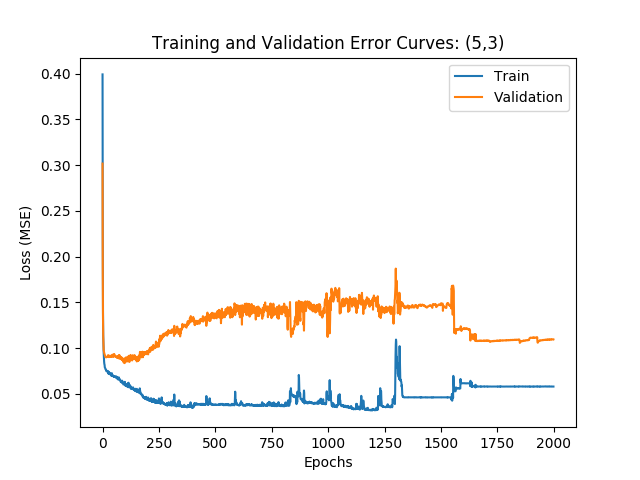

<IPython.core.display.Javascript object>


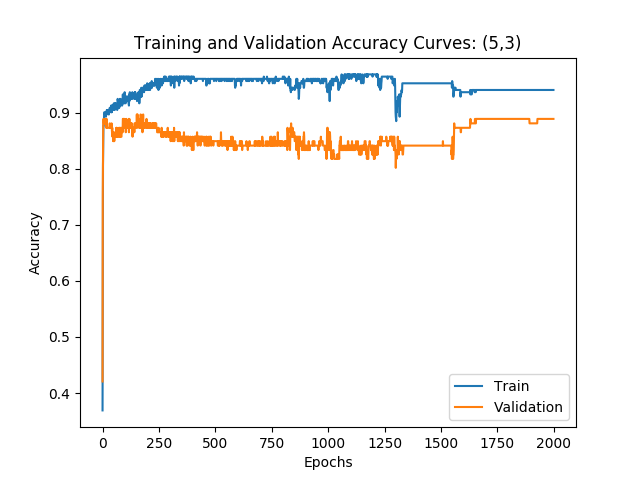

Matriz de confusão
[[1646  252]
 [   5   59]]

Train Loss:       0.0600
Validation Loss:  0.0836
Accuracy:         0.8690
MSE:              0.1310
AUROC:            0.9329


In [129]:
plot_training_error_curves(history, "(5,3)")
plot_training_acc_curves(history, "(5,3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [91]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4012 - acc: 0.4921 - val_loss: 0.3508 - val_acc: 0.4921
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3089 - acc: 0.5119 - val_loss: 0.2538 - val_acc: 0.6111
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2271 - acc: 0.6865 - val_loss: 0.1899 - val_acc: 0.7540
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1743 - acc: 0.7817 - val_loss: 0.1556 - val_acc: 0.8016
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1423 - acc: 0.8175 - val_loss: 0.1446 - val_acc: 0.8095
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1309 - acc: 0.8452 - val_loss: 0.1519 - val_acc: 0.8413
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1219 - acc: 0.8651 - val_loss: 0.1506 - val_acc: 0.8730
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1192 - acc

252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.9048 - val_loss: 0.1473 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0933 - acc: 0.9048 - val_loss: 0.1464 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8968 - val_loss: 0.1455 - val_acc: 0.8571
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0925 - acc: 0.8968 - val_loss: 0.1436 - val_acc: 0.8571
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8929 - val_loss: 0.1420 - val_acc: 0.8571
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0916 - acc: 0.8968 - val_loss: 0.1402 - val_acc: 0.8651
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1355 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8929 - val_loss: 0.1384 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1155 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1188 - val_acc: 0.8571
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1145 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1192 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1174 - val_acc: 0.8571
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1168 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1191 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1175 - val_acc: 0.8571
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1159 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1163 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1179 - val_acc: 0.8571
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1184 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1158 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1196 - val_acc: 0.8571
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1202 - val_acc: 0.8651
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1168 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1168 - val_acc: 0.8571
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1195 - val_acc: 0.8651
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1184 - val_acc: 0.8571
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1176 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1202 - val_acc: 0.8571
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8651
Epoch 773/2000
252/252 [==============================] - ETA: 0s - loss: 0.0962 - acc: 0.875 - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1166 - val_acc: 0.8571
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1206 - val_acc: 0.8651
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.900

252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1201 - val_acc: 0.8651
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8571
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1184 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8651
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1159 - val_acc: 0.8651
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1185 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.8571
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1149 - val_acc: 0.8651
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9008 - val_loss: 0.1181 - val_acc: 0.8651
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1173 - val_acc: 0.8571
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9008 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9008 - val_loss: 0.1209 - val_acc: 0.8571
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1166 - val_acc:

252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8571
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9048 - val_loss: 0.1184 - val_acc: 0.8571
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1156 - val_acc: 0.8571
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1181 - val_acc: 0.8651
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1167 - val_acc: 0.8651
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1186 - val_acc: 0.8651
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1155 - val_acc:

252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1181 - val_acc: 0.8571
Epoch 1280/2000
252/252 [==============================] - ETA: 0s - loss: 0.0682 - acc: 0.906 - 0s - loss: 0.0788 - acc: 0.9008 - val_loss: 0.1203 - val_acc: 0.8651
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9008 - val_loss: 0.1169 - val_acc: 0.8651
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1176 - val_acc: 0.8651
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc

252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1180 - val_acc: 0.8651
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1162 - val_acc: 0.8651
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1198 - val_acc: 0.8651
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9008 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1173 - val_acc: 0.8651
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8651
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1180 - val_acc:

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1187 - val_acc: 0.8571
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0794 - acc: 0.9048 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.8651
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1194 - val_acc: 0.8651
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1160 - val_acc: 0.8651
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1178 - val_acc: 0.8571
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.9048 - val_loss: 0.1193 - val_acc: 0.8571
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9008 - val_loss: 0.1151 - val_acc:

252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1186 - val_acc: 0.8571
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9048 - val_loss: 0.1147 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1179 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.9008 - val_loss: 0.1208 - val_acc: 0.8571
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1183 - val_acc:

252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1164 - val_acc: 0.8651
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0789 - acc: 0.9048 - val_loss: 0.1147 - val_acc: 0.8651
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9048 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0786 - acc: 0.9048 - val_loss: 0.1193 - val_acc: 0.8651
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1185 - val_acc: 0.8651
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1161 - val_acc: 0.8651
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1168 - val_acc:

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9008 - val_loss: 0.1204 - val_acc: 0.8651
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0788 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8651
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1153 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0791 - acc: 0.9048 - val_loss: 0.1161 - val_acc: 0.8651
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0790 - acc: 0.9048 - val_loss: 0.1188 - val_acc: 0.8571
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9048 - val_loss: 0.1165 - val_acc: 0.8651
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0787 - acc: 0.9008 - val_loss: 0.1183 - val_acc: 0.8571
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1176 - val_acc:

In [92]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.06902084823519325, 0.87512742087746254]


/home/opcinove/.virtualenvs/python3.6env/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


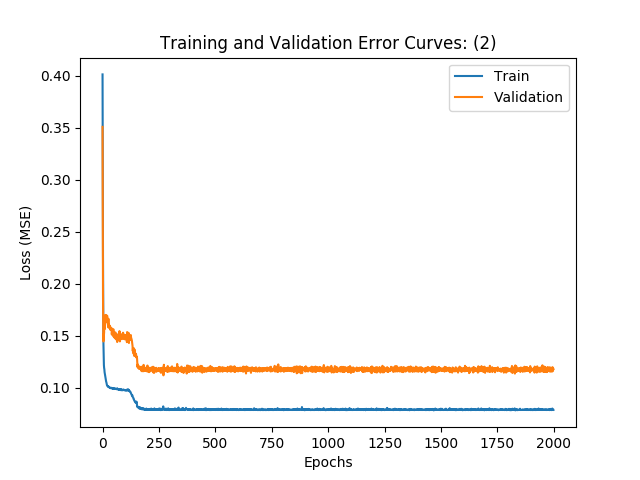

<IPython.core.display.Javascript object>


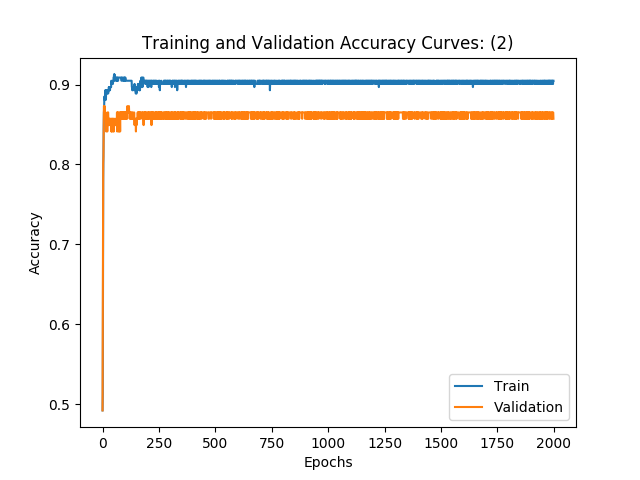

Matriz de confusão
[[1660  238]
 [   6   58]]

Train Loss:       0.0808
Validation Loss:  0.1121
Accuracy:         0.8756
MSE:              0.1244
AUROC:            0.9348


In [93]:
plot_training_error_curves(history, "(2)")
plot_training_acc_curves(history, "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [94]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5802 - acc: 0.3611 - val_loss: 0.5293 - val_acc: 0.4048
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5169 - acc: 0.4802 - val_loss: 0.5031 - val_acc: 0.5000
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5015 - acc: 0.5000 - val_loss: 0.4988 - val_acc: 0.5000
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5001 - acc: 0.5000 - val_loss: 0.4990 - val_acc: 0.5000
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4999 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4997 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4996 - acc: 0.5000 - val_loss: 0.5002 - val_acc: 0.5000
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4994 - acc

252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9127 - val_loss: 0.1131 - val_acc: 0.8651
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0733 - acc: 0.9127 - val_loss: 0.1140 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1138 - val_acc: 0.8571
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9127 - val_loss: 0.1149 - val_acc: 0.8571
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9087 - val_loss: 0.1160 - val_acc: 0.8571
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0726 - acc: 0.9127 - val_loss: 0.1132 - val_acc: 0.8571
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9087 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.9087 - val_loss: 0.1151 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1272 - val_acc: 0.8651
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9325 - val_loss: 0.1265 - val_acc: 0.8651
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9286 - val_loss: 0.1314 - val_acc: 0.8651
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.1268 - val_acc: 0.8651
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9286 - val_loss: 0.1291 - val_acc: 0.8651
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9325 - val_loss: 0.1275 - val_acc: 0.8571
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9286 - val_loss: 0.1283 - val_acc: 0.8651
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9325 - val_loss: 0.1297 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9325 - val_loss: 0.1299 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9325 - val_loss: 0.1282 - val_acc: 0.8571
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9286 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9325 - val_loss: 0.1280 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1308 - val_acc: 0.8571
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1268 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9325 - val_loss: 0.1271 - val_acc: 0.8651
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9325 - val_loss: 0.1331 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1272 - val_acc: 0.8571
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9246 - val_loss: 0.1283 - val_acc: 0.8492
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9246 - val_loss: 0.1311 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9246 - val_loss: 0.1237 - val_acc: 0.8730
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9325 - val_loss: 0.1278 - val_acc: 0.8571
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9286 - val_loss: 0.1293 - val_acc: 0.8730
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1238 - val_acc: 0.8571
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9246 - val_loss: 0.1273 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1286 - val_acc: 0.8651
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1256 - val_acc: 0.8651
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1286 - val_acc: 0.8571
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9286 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1269 - val_acc: 0.8651
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1260 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9365 - val_loss: 0.1243 - val_acc: 0.8571
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9325 - val_loss: 0.1269 - val_acc: 0.8651
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9286 - val_loss: 0.1279 - val_acc: 0.8651
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1315 - val_acc: 0.8651
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9286 - val_loss: 0.1280 - val_acc: 0.8651
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9325 - val_loss: 0.1246 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9286 - val_loss: 0.1293 - val_acc: 0.8571
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.1268 - val_acc: 0.8571
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9286 - val_loss: 0.1287 - val_acc: 0.8651
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1260 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1284 - val_acc: 0.8571
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9286 - val_loss: 0.1322 - val_acc: 0.8571
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1267 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9325 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1289 - val_acc: 0.8571
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1294 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1288 - val_acc: 0.8651
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1271 - val_acc: 0.8651
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9325 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1269 - val_acc:

252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1263 - val_acc: 0.8571
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0670 - acc: 0.9325 - val_loss: 0.1309 - val_acc: 0.8651
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9325 - val_loss: 0.1297 - val_acc: 0.8571
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9286 - val_loss: 0.1304 - val_acc: 0.8651
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1275 - val_acc: 0.8492
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0668 - acc: 0.9286 - val_loss: 0.1304 - val_acc: 0.8651
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1260 - val_acc: 0.8651
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9325 - val_loss: 0.1292 - val_acc:

252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1295 - val_acc: 0.8651
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1271 - val_acc: 0.8571
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9286 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0669 - acc: 0.9286 - val_loss: 0.1276 - val_acc: 0.8651
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1281 - val_acc: 0.8651
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9365 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1295 - val_acc:

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1301 - val_acc: 0.8651
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1278 - val_acc: 0.8651
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9365 - val_loss: 0.1281 - val_acc: 0.8651
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9286 - val_loss: 0.1303 - val_acc: 0.8651
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1273 - val_acc: 0.8651
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1311 - val_acc:

252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9286 - val_loss: 0.1273 - val_acc: 0.8651
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9365 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9325 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1318 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9286 - val_loss: 0.1256 - val_acc: 0.8651
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9286 - val_loss: 0.1307 - val_acc: 0.8651
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9286 - val_loss: 0.1271 - val_acc: 0.8492
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.1279 - val_acc:

252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9325 - val_loss: 0.1268 - val_acc: 0.8651
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9286 - val_loss: 0.1300 - val_acc: 0.8651
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9325 - val_loss: 0.1298 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9325 - val_loss: 0.1277 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0667 - acc: 0.9286 - val_loss: 0.1304 - val_acc: 0.8651
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0663 - acc: 0.9325 - val_loss: 0.1274 - val_acc: 0.8571
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9325 - val_loss: 0.1271 - val_acc: 0.8651
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1293 - val_acc:

252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1344 - val_acc: 0.8730
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1271 - val_acc: 0.8571
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9286 - val_loss: 0.1294 - val_acc: 0.8651
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1286 - val_acc: 0.8651
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9286 - val_loss: 0.1296 - val_acc: 0.8651
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9286 - val_loss: 0.1264 - val_acc: 0.8571
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9286 - val_loss: 0.1320 - val_acc: 0.8651
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1289 - val_acc:

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1295 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0666 - acc: 0.9286 - val_loss: 0.1294 - val_acc: 0.8651
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9325 - val_loss: 0.1282 - val_acc: 0.8651
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1306 - val_acc: 0.8651
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0665 - acc: 0.9286 - val_loss: 0.1279 - val_acc: 0.8651
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1319 - val_acc: 0.8651
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9286 - val_loss: 0.1261 - val_acc: 0.8571
Epoch 1926/2000
252/252 [==============================] - 0s - loss: 0.0664 - acc: 0.9325 - val_loss: 0.1285 - val_acc:

In [95]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1962/1962 [==============================] - 0s     
[0.073499742242204791, 0.89908256868582137]


/home/opcinove/.virtualenvs/python3.6env/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


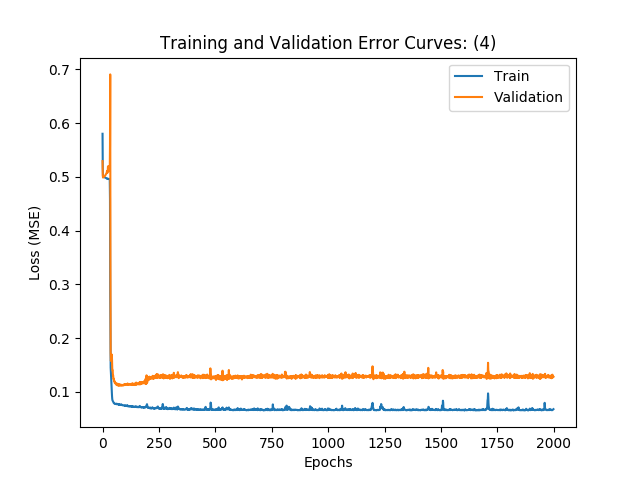

<IPython.core.display.Javascript object>


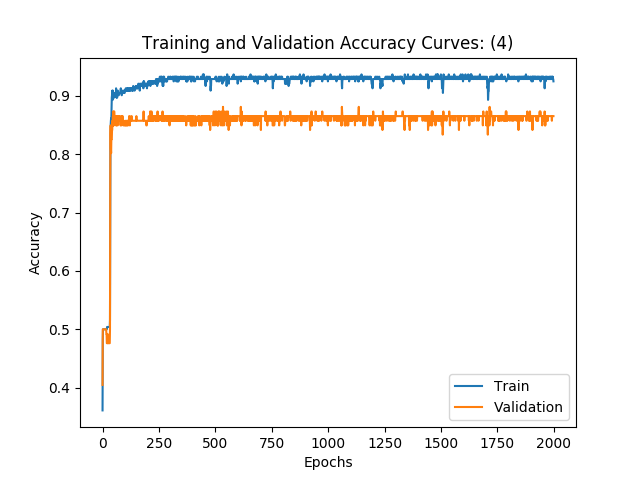

Matriz de confusão
[[1709  189]
 [   8   56]]

Train Loss:       0.0770
Validation Loss:  0.1116
Accuracy:         0.8996
MSE:              0.1004
AUROC:            0.9144


In [96]:
plot_training_error_curves(history, "(4)")
plot_training_acc_curves(history, "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))